# <center>**01_preprocess_dicom_luts**</center>

### Table of Contents

1. **Notebook Overview**  
   - Objective of the DICOM preprocessing pipeline  
   - Rationale for demonstrating the workflow  
   - Role of consistent preprocessing in the downstream deep learning and hybrid ML pipelines  

2. **Environment Setup**  
   - Import of required scientific, imaging, and DICOM libraries  
   - Import of project-specific utilities (U-Net–based cropping model)

3. **Loading the U-Net Segmentation Model**  
   - Load the trained U-Net/UNet++ model used for anatomical cropping  
   - Explanation of when the `crop_unet` option is used  

4. **DICOM Preprocessing Function**  
   - Reading DICOM files and extracting `pixel_array`  
   - Application of window center and window width  
   - Optional intensity inversion  
   - Cropping or padding to obtain square fields of view (`crop`, `padding`, `crop_unet`)  
   - Resizing, normalization, and RGB channel expansion  
   - Robust metadata extraction and safe file export  
   - Generation of structured metadata tables (`.npy`, `.csv`, `.xlsx`)  

5. **Run Preprocessing**  
   - Apply the full pipeline to the external dataset  

6. **Summary and Conclusions**  
   - Role of standardized preprocessing in reproducible ML and DL experiments  
   - Considerations for future datasets or imaging modalities  
   - How this preprocessing step integrates with the upcoming feature extraction and model training notebooks  


### **1. Notebook Overview**

This notebook implements a standardized DICOM preprocessing pipeline for radiographic images, transforming raw DICOM files into normalized, fixed-size RGB tensors accompanied by structured metadata. The processing steps include windowing, optional intensity inversion, cropping or padding to obtain square images, resizing to a common spatial resolution, and normalization of pixel intensities. The resulting `.npy` tensors and metadata tables provide a consistent interface for later stages of the project, including deep feature extraction and classical machine learning models.

Note on Dataset Selection: For demonstration purposes, this notebook utilizes a small, complementary dataset to illustrate the end-to-end pipeline. The primary datasets used in the main research are not fully processed step-by-step in this document due to their substantial computational weight and large storage requirements.

A central objective of this notebook is to ensure that all images entering the downstream deep learning and hybrid machine learning pipelines share the same preprocessing assumptions. By enforcing consistent windowing, spatial normalization and intensity scaling across datasets, we reduce variability introduced by acquisition and scanner differences, and we make it easier to reproduce experiments. The preprocessed outputs generated here serve as the input for subsequent notebooks dedicated to deep feature extraction, hybrid CNN + ML pipelines, and final model training and evaluation.


### **2. Environment Setup**

In [1]:
# Standard library
import os
import shutil
import warnings

# Third-party scientific and image processing libraries
import numpy as np
import pandas as pd
import cv2
import torch
import matplotlib.pyplot as plt
from matplotlib.pyplot import imsave

# DICOM handling
import pydicom
from pydicom import pixel_data_handlers as handlers
from pydicom.pixel_data_handlers.util import apply_windowing as handlers_apply_windowing

# Progress bars 
from tqdm.notebook import tqdm

# Project-specific utilities (U-Net based cropping)
from utilidades_cropping_unet import Humerus_model, crop_image


### **3. Loading the U-Net Segmentation Model**

In [6]:
# Load the U-Net++ segmentation model

# This model is used only when the preprocessing operation is set to
# "crop_unet". It performs an anatomical region–based crop on the
# resized RGB image before saving the final preprocessed output.

model_saved_path = "UnetPlusPlus_efficientnet-b2_25.ckpt"

model = Humerus_model.load_from_checkpoint(
    checkpoint_path=model_saved_path,
    arch="UnetPlusPlus",
    encoder_name="efficientnet-b2",
    in_channels=3,
    out_classes=1,
    map_location="cpu",
)

# Set model to evaluation mode
model = model.cpu()
model.eval()

Humerus_model(
  (model): UnetPlusPlus(
    (encoder): EfficientNetEncoder(
      (_conv_stem): Conv2dStaticSamePadding(
        3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
        (static_padding): ZeroPad2d((0, 1, 0, 1))
      )
      (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_blocks): ModuleList(
        (0): MBConvBlock(
          (_expand_conv): Identity()
          (_bn0): Identity()
          (_depthwise_conv): Conv2dStaticSamePadding(
            32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
            (static_padding): ZeroPad2d((1, 1, 1, 1))
          )
          (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
          (_se_reduce): Conv2dStaticSamePadding(
            32, 8, kernel_size=(1, 1), stride=(1, 1)
            (static_padding): Identity()
          )
          (_se_expand): Conv2dStaticSamePadding(
            

### **4. DICOM Preprocessing Function**

In [7]:
def transform_dicom_series(
    origin_dir: str,
    final_dir: str,
    size: int = 512,
    operation: str = "crop",
    model=None,
    invert: bool = False,
    plot: bool = False,
) -> None:
    """
    Preprocess a series of DICOM images with the following steps:
      1. Read DICOM files and extract pixel data.
      2. Optionally invert image intensities.
      3. Apply window center and window width.
      4. Crop or pad the image to obtain a square field of view.
      5. Resize the image to the desired size.
      6. Normalize pixel intensities to [0, 1].
      7. Convert the final image to RGB (3 channels).
      8. Optionally apply an additional cropping step using a model
         (for operation == "crop_unet").

    Normalization is intentionally performed as the last step, to avoid
    interpolation operations (during resizing) altering the normalized values.

    Parameters
    ----------
    origin_dir : str
        Path to the root folder containing the DICOM images.
    final_dir : str
        Path to the folder where preprocessed images and metadata will be saved.
    size : int, optional
        Final spatial size (height and width) of the preprocessed images.
        Defaults to 512.
    operation : str, optional
        Spatial adjustment to obtain a square image:
        - "crop": crop the longer dimension.
        - "crop_unet": same as "crop", then additional model-based crop.
        - "padding": pad the shorter dimension with zeros.
        Defaults to "crop".
    model : object, optional
        Model used for additional cropping when operation == "crop_unet".
        It is ignored for other operations. Defaults to None.
    invert : bool, optional
        If True, invert the image intensities after reading the pixel data.
        Defaults to False.
    plot : bool, optional
        If True and operation == "crop_unet", the crop function may display
        intermediate visualizations (depending on the implementation of
        `crop_image`). Defaults to False.

    Returns
    -------
    None
        The function saves:
        - One .npy file per image with the preprocessed RGB array.
        - A NumPy array with metadata: `path_dicom_data.npy`.
        - An Excel file with metadata: `path_dicom_data.xlsx`.
        - A CSV file with metadata: `path_dicom_data.csv`.
    """
    operation = operation.lower()

    # Ensure the output directory exists
    os.makedirs(final_dir, exist_ok=True)

    metadata_records = []

    for root, dirs, files in tqdm(os.walk(origin_dir, topdown=False)):
        for file in files:
            if not file.endswith(".dcm"):
                continue

            file_path = os.path.join(root, file)

            try:
                # Read DICOM file and pixel data
                ds = pydicom.dcmread(file_path)
                pixel_array = ds.pixel_array.astype(np.float32)

                # Compute maximum representable value based on BitsStored
                largest_image_pixel_value = float(2 ** ds.BitsStored)

                # Optional inversion of intensities
                if invert:
                    pixel_array = largest_image_pixel_value - pixel_array

                # Set windowing parameters and apply windowing
                ds.WindowCenter = largest_image_pixel_value / 2.0
                ds.WindowWidth = largest_image_pixel_value
                pixel_array_windowed = handlers.apply_windowing(pixel_array, ds)

                height, width = pixel_array_windowed.shape

                # Apply cropping or padding to obtain a square image
                if operation in ("crop", "crop_unet"):
                    min_dim = min(height, width)
                    major_axis = int(np.argmax(pixel_array_windowed.shape))

                    # height >= width
                    if major_axis == 0:
                        pixel_array_windowed = pixel_array_windowed[0:min_dim, :]
                    # width >= height
                    else:
                        # Lateral decision based on filename (I/D)
                        lateral_prefix = os.path.split(file_path)[1][0]
                        if lateral_prefix == "I":
                            pixel_array_windowed = pixel_array_windowed[:, width - min_dim :]
                        elif lateral_prefix == "D":
                            pixel_array_windowed = pixel_array_windowed[:, 0:min_dim]
                        else:
                            # Default: center crop if lateral prefix is not recognized
                            start_col = (width - min_dim) // 2
                            pixel_array_windowed = pixel_array_windowed[:, start_col : start_col + min_dim]

                elif operation == "padding":
                    max_dim = max(height, width)
                    pad_top = (max_dim - height) // 2
                    pad_bottom = max_dim - height - pad_top
                    pad_left = (max_dim - width) // 2
                    pad_right = max_dim - width - pad_left
                    pixel_array_windowed = cv2.copyMakeBorder(
                        pixel_array_windowed,
                        pad_top,
                        pad_bottom,
                        pad_left,
                        pad_right,
                        borderType=cv2.BORDER_CONSTANT,
                        value=0,
                    )

                # Resize to target size
                pixel_array_resized = cv2.resize(
                    pixel_array_windowed,
                    (size, size),
                    interpolation=cv2.INTER_CUBIC,
                )

                # Normalize to [0, 1]
                max_val = np.max(pixel_array_resized)
                if max_val > 0:
                    pixel_array_normalized = pixel_array_resized / max_val
                else:
                    pixel_array_normalized = pixel_array_resized

                # Convert to RGB (3 channels)
                pixel_array_rgb = np.stack(
                    [pixel_array_normalized] * 3,
                    axis=-1,
                )

                # Optional model-based cropping (e.g. U-Net) after normalization
                if operation == "crop_unet":
                    pixel_array_rgb = crop_image(
                        pixel_array_rgb,
                        model,
                        visualizar=plot,
                    )

                # Episode and projection information from the path/filename
                episode_id = os.path.split(root)[1]
                lat = os.path.split(file_path)[1][0]
                project = os.path.split(file_path)[1][2:4]

                # DICOM metadata
                nhc = ds.get((0x0010, 0x0020), "").value if (0x0010, 0x0020) in ds else ""
                manufacturer = ds.get((0x0008, 0x0070), "").value if (0x0008, 0x0070) in ds else ""
                manufacturer_model = ds.get((0x0008, 0x1090), "").value if (0x0008, 0x1090) in ds else ""
                station_name = ds.get((0x0008, 0x1010), "").value if (0x0008, 0x1010) in ds else ""
                voilutfunction = ds.get((0x0028, 0x1056), "").value if (0x0028, 0x1056) in ds else ""

                birthdate = ds.get((0x0010, 0x0030), "").value if (0x0010, 0x0030) in ds else ""
                sex = ds.get((0x0010, 0x0040), "").value if (0x0010, 0x0040) in ds else ""

                try:
                    ei = ds[(0x0018, 0x1150)].value
                except Exception:
                    ei = np.nan

                # Construct a unique radiograph identifier
                rx_id = f"{episode_id}_{lat}_{project}"

                # Save the processed image as a NumPy array
                image_out_path = os.path.join(final_dir, f"{rx_id}.npy")
                np.save(image_out_path, pixel_array_rgb)

                # Collect metadata record
                metadata_records.append(
                    (
                        nhc,
                        episode_id,
                        rx_id,
                        lat,
                        project,
                        manufacturer,
                        manufacturer_model,
                        station_name,
                        voilutfunction,
                        birthdate,
                        sex,
                        ei,
                    )
                )

            except Exception as e:
                print(f"ERROR processing {file_path}: {e}")

    # Convert metadata to NumPy array and DataFrame
    metadata_array = np.array(metadata_records, dtype=object)
    df_metadata = pd.DataFrame(
        data=metadata_array,
        columns=[
            "NHC",
            "episode_id",
            "rx_id",
            "lat",
            "project",
            "manufacturer",
            "manufacturer_model",
            "station_name",
            "voilutfunction",
            "birthdate",
            "sex",
            "ei",
        ],
    )

    # Save metadata files
    np.save(os.path.join(final_dir, "path_dicom_data.npy"), metadata_array)
    df_metadata.to_excel(os.path.join(final_dir, "path_dicom_data.xlsx"), index=False)
    df_metadata.to_csv(os.path.join(final_dir, "path_dicom_data.csv"), index=False)

    # Quick report
    print("\nDICOM preprocessing completed.")
    print("Number of images processed:", len(metadata_records))
    print("Metadata array shape:", metadata_array.shape)


### **5. Run Preprocessing**

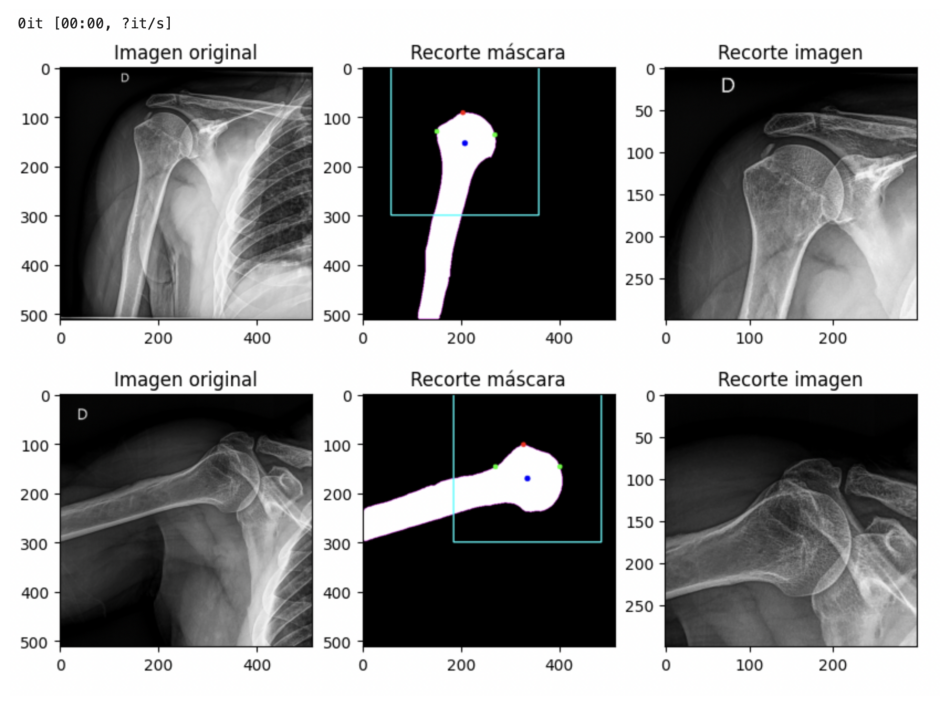

In [5]:
# DICOM preprocessing

# Note: For demonstration purposes in this notebook, the output is limited 
# to only two examples to illustrate the pipeline's performance 
# while maintaining a lightweight execution.

# Actual preprocessing call
transform_dicom_series(
    origin_dir="Images_X_rays",
    final_dir="Images_all_X_rays",
    size=512,
    operation="crop_unet",
    model=model,
    invert=False,
    plot=True,
)


### **6. Summary and Conclusions**

In this notebook we established a standardized DICOM preprocessing pipeline that converts heterogeneous radiographic studies into a unified representation suitable for machine learning. Each DICOM file is read, windowed, optionally inverted, cropped or padded to a square field of view, resized to a fixed resolution and normalized before being stored as a 3-channel RGB tensor. Alongside each image, a set of key DICOM attributes is extracted and stored as structured metadata, preserving the linkage between preprocessed images and their clinical and technical acquisition context.

By applying the same preprocessing function to the complementary dataset, we provide a reproducible and scalable approach that can be extended to additional datasets or imaging modalities in the future. The design choices made here—such as separating generic preprocessing from optional model-based cropping and using explicit output directories per dataset—facilitate adaptation to new data sources, different anatomical regions or alternative segmentation models without needing to rearchitect the pipeline.

The outputs generated by this notebook form the foundation for the next stages of the project. The preprocessed image tensors and associated metadata will be consumed by subsequent notebooks that perform deep feature extraction using convolutional neural networks and train hybrid ML models on top of those features. Ensuring that all images share a consistent preprocessing history simplifies the interpretation of downstream results and supports rigorous comparison between models, datasets and experimental configurations.